# Theoretical Computer Sciences Project

#### Sergio Peignier and Théotime Grohens

\section{1 - Graph Therory}

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

\subsection{1.1 Introduction}

In this project we will apply graph algorithms to study the gene regulatory network (GRN)
of \textit{Saccharomyces cerevisiae}.
This species of yeast, it is a small single-cell eukaryote, with a short generation time, and
two possible forms: an haploid one and a diploid one. Moreover, this organism can be easily
cultured, and it has an important economic impact since it is extensively used for instance,
in winemaking, baking, and brewing. Due to these characteristics, Saccharomyces cerevisiae
is studied as an important model organism.

In this work we will study the gene regulatory network of \textit{Saccharomyces cerevisiae },
using graph theory algorithms. The files that are provided for this project have been used
in [MCK+12] , as gold-standards to assess gene regulatory network inference algorithms, and
they are the result of biological experiments based on ChIP binding data [MWG + 06], and
1systematic transcription factor deletions [HKI07]. Hereafter we describe each dataset in
details:

\begin{itemize}
\item GRN edges S cerevisiae.txt: contains the edges of the S. cervisiae regulatory network
(from transcription factors to target genes). The intended meaning is that if there is
an edge between transcription factor X and the target gene A, then X regulates the
transcription of A;

\item net4 transcription factors.tsv: Is a file containing in a single column the identifiers of the transcription factors of S. cervisiae that were studied;

\item net4 gene ids.tsv: The two previous files, use specific identifiers to denote genes, and this file contains the gene name associated to each gene identifier;

\item go slim mapping.tab.txt: Only columns 0 and 5 will be used in this work. Column 0 contains the gene name, and column 5 contains its Gene Ontology (GO) annotation
(http://www.geneontology.org/). Notice that two different rows may give for the
same gene different Gene Ontology annotations. 
\end{itemize}

\subsection{1.2 Exercices}

\textbf{Exercise 1 : } Exploration and characterization of the gene regulatory network}

1) Load the dataset and create a NetworkX graph instance.

On importe les datasets avec paandas : 

In [102]:
GRN_edges_SC = pd.read_csv("./datas/GRN_edges_S_cerevisiae.txt", sep = ',',  header=0)
net4_transcription_factors = pd.read_csv("./datas/net4_transcription_factors.tsv", sep = '\n',  header=0) 
net4_gene_ids = pd.read_csv("./datas/net4_gene_ids.tsv", sep = '\t', header=0) 
go_slim_mappingtab = pd.read_csv("./datas/go_slim_mapping.tab.txt", sep = '\t', header=None) 

On vérifie que tout a bien été importé 

In [103]:
GRN_edges_SC = GRN_edges_SC.iloc[:,1:]

In [112]:
# on peut transformer le df en array (au cas où si besoin)
GRN_edges_SC_np = GRN_edges_SC.to_numpy()

In [105]:
net4_gene_ids.head()

,ID,Name
0,G1,YHR084W
1,G2,YER109C
2,G3,YDR496C
3,G4,YBR098W
4,G5,YNL139C


In [106]:
net4_transcription_factors.head()

,transcription_factor
0,G1
1,G2
2,G3
3,G4
4,G5


In [107]:
go_slim_mappingtab.head()

,0,1,2,3,4,5,6
0,HRA1,HRA1,S000119380,C,cellular_component,GO:0005575,ncRNA_gene
1,HRA1,HRA1,S000119380,F,molecular_function,GO:0003674,ncRNA_gene
2,HRA1,HRA1,S000119380,P,rRNA processing,GO:0006364,ncRNA_gene
3,HRA1,HRA1,S000119380,P,ribosomal small subunit biogenesis,GO:0042274,ncRNA_gene
4,ICR1,ICR1,S000132612,C,nucleus,GO:0005634,ncRNA_gene


In [113]:
GRN_edges_SC.head()

,transcription_factor,target_gene
0,G15,G1
1,G98,G1
2,G109,G1
3,G22,G9
4,G211,G11


In [124]:
G = nx.from_pandas_edgelist(GRN_edges_SC, "transcription_factor", "target_gene")

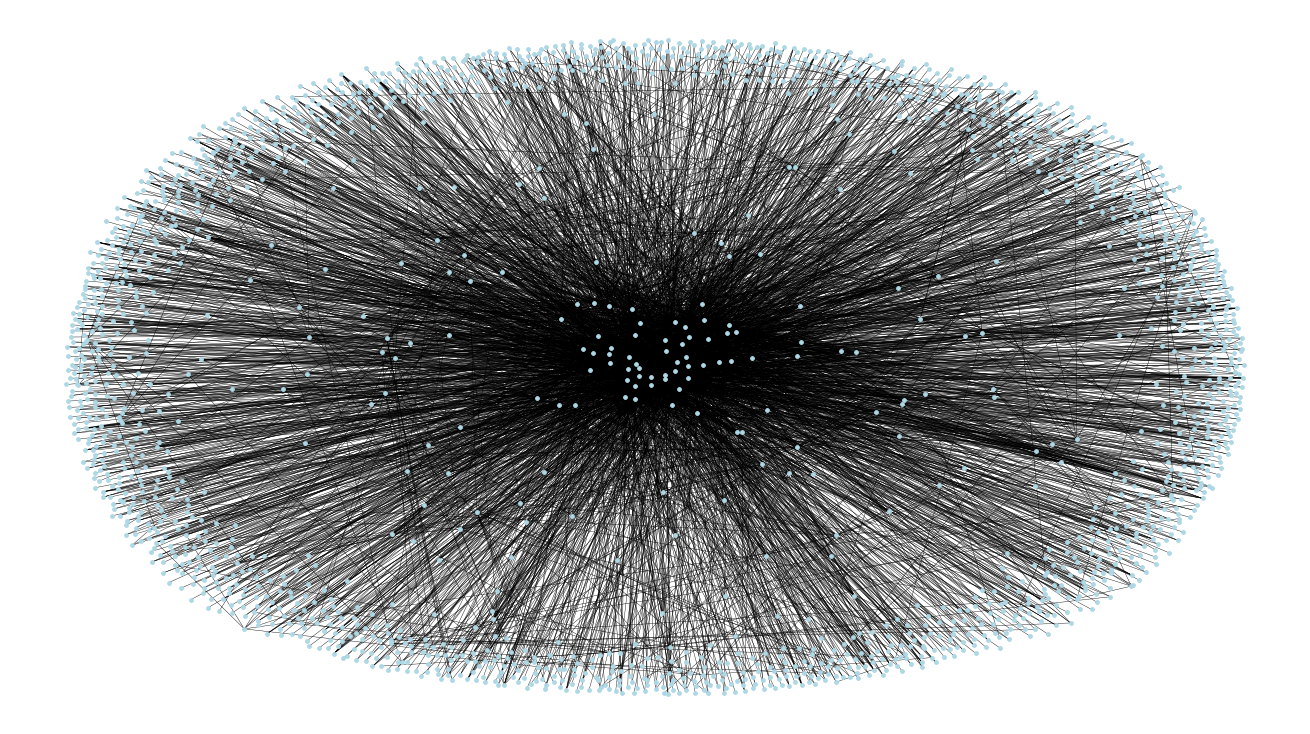

In [140]:
plt.figure(figsize=(18,10))
pos = nx.spring_layout(G, k = 0.6,) #return the relative positions of the nodes,k = optimal distance between nodes
nx.draw(G, node_size = 14, 
        pos = pos, 
        width = 0.4, 
        node_color = 'lightblue')